In [1]:
import torch
import torch.nn as nn

# Import the gym module
import gym
import numpy as np
import time 

from matplotlib import pyplot as plt

import random

import gym
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

In [2]:
class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=10):
        '''첫 번째 트릭 No-Operation. 초기화 후 일정 단계에 이를때까지 아무 행동도 하지않고
        게임 초기 상태를 다양하게 하여 특정 시작 상태만 학습하는 것을 방지한다'''

        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(
                1, self.noop_max + 1)  # pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)


In [3]:
# Create a breakout environment
env = gym.make('BreakoutNoFrameskip-v4')
env = NoopResetEnv(env, noop_max=30)

In [4]:
def preprocess(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.resize(img, (84, 84), interpolation=cv2.INTER_AREA)
    return np.expand_dims(img, 0) # (1, 80, 80)

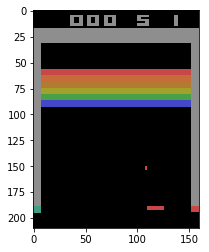

In [5]:
env.reset()
img = plt.imshow(env.render(mode='rgb_array')) # only call this once
for _ in range(30):
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    env.step(action)

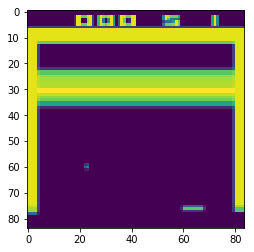

In [6]:
env.reset()
for _ in range(30):
    s, _, _, _ = env.step(env.action_space.sample())

plt.imshow(preprocess(s)[0])

In [7]:
from collections import deque
import random 

class ReplayMemory(object):
    def __init__(self, capacity):
        self.deque = deque(maxlen=capacity)

    def append(self, state, action, reward, next_state, done):
        if np.ndim(state) and np.ndim(next_state) == 1:
            state = np.expand_dims(state, 0)
            next_state = np.expand_dims(next_state, 0)
            
        self.deque.append((state, action, reward, next_state, done))

    def pop_episode(self):
        state, action, reward, next_state, done = zip(*[self.deque.popleft() for _ in range(len(self))])
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def reset(self):
        [self.deque.pop() for _ in range(len(self))]
        return
        
    def __len__(self):
        return len(self.deque)

In [8]:
class FrameHistory(object):
    # consecutive frame을 4개씩 병합하여 새로운 x를 하나씩 만드는 클래스
    # 만들어진 x는 4개씩 concat하고 s를 만들어서 DQN의 input으로 들어감
    def __init__(self, env, k=4):
        self.state_deque = deque(maxlen=k) # [x1, x2, x3, x4]
        self.frame_history_deque = deque(maxlen=k) #[s1, s2, s3, s4]
        self.k = k
        
        # 최초에는 초기 화면(env.reset)으로 채워둠
        self.env = env
        self.initial_state = self.preprocess(self.env.reset())
        self.reset()
        
    def preprocess(self, img):
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = cv2.resize(img, (84, 84), interpolation=cv2.INTER_AREA)
        return np.expand_dims(img, 0) # (1, 80, 80)
    
    def append_frame(self, s):
        # if full, aggregate and clear old frames, append new frame to history queue
        self.frame_history_deque.append(self.preprocess(s))
        
        if len(self) == self.k:
            self.state_deque.append(self.aggregate_frame())
        return
        
    def aggregate_frame(self):
        if len(self) < self.k:
            raise ValueError('not enough frames in history, expected %s, but got %s'%(self.k, len(self)))
        
        # element-wise maximum to aggregate
        frame_history = [self.frame_history_deque.popleft() for _ in range(self.k)]
        return np.maximum.reduce(frame_history[-2:]) #마지막 2 프레임 사용 
    
    def get_state(self):
        S = np.array([self.state_deque[i] for i in range(self.k)]) # S = [x1, x2, x3, x4], (4, 1, 80, 80)
        S = np.swapaxes(S, 0, 1) # (1, 4, 80, 80)
        return S
    
    def reset(self):
        self.frame_history_deque = deque(maxlen=k)
        self.state_deque = deque(maxlen=k)
        
        for _ in range(self.k):
            self.state_deque.append(self.initial_state)
    
    def __len__(self):
        return len(self.frame_history_deque)

In [14]:
class ActorCritic(nn.Module):
    def __init__(self, in_dim, n_action):
        super(ActorCritic, self).__init__()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_dim, 32, (8, 8), stride=4), nn.ReLU(), # conv 1
            nn.Conv2d(32, 64, (4, 4), stride=2), nn.ReLU(), # conv 2
            nn.Conv2d(64, 64, (3, 3), stride=1), nn.ReLU() # conv 3
        )
        
        self.actor_lin = nn.Sequential(
                nn.Linear(64*7*7, 512), nn.ReLU(), # hidden layer
                nn.Linear(512, n_action)
            )
        
        self.critic_lin = nn.Sequential(
                nn.Linear(64*7*7, 512), nn.ReLU(), # hidden layer
                nn.Linear(512, 1)
            )

    def to_tensor(self, img):
        img = torch.tensor(img, dtype=torch.float32, device=self.device).cuda(non_blocking=True) # to tensor
        img /= 255                                   # normalize into 0-1
        while img.dim() < 4 :                        # 4-dim
            img = img.unsqueeze(0)
        return img
        
    def forward(self, frames):
        frames = self.to_tensor(frames) 
        conved = self.conv(frames)
        conved = conved.view(conved.size(0), -1)
        
        action_prob = self.actor_lin(conved)
        action_prob = torch.softmax(action_prob, dim=-1)
        advantage = self.critic_lin(conved).squeeze(1) # dim=1
        return action_prob, advantage

In [15]:
import torch.nn.init as init

def weight_init(m):
    '''
    Usage:
        model = Model()
        model.apply(weight_init)
    '''
    if isinstance(m, nn.Conv2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)

    elif isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight.data)
        init.normal_(m.bias.data)
    return

In [ ]:
#############
k = 4 ## number of skipped frame
#############

actor_critic = ActorCritic(in_dim=k, n_action=4)
actor_critic.to(actor_critic.device) # model to cuda
actor_critic.apply(weight_init)

In [18]:
class Fitter():
    def __init__(self, env, actor_critic, target_net, k=4, train_method='DQN'):
        self.env = env
        self.train_method = train_method
        self.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        self.save_path = ('Breakout_vanilla_actor_critic_state_dict')

        # networks
        self.actor_critic = actor_critic
        self.actor_critic.to(self.actor_critic.device) # model to cuda
        
        # train parameters
        self.gamma = 0.99 #as written in paper
        self.criterion = nn.SmoothL1Loss() # huber loss (error-clipping)
        self.optim = torch.optim.RMSprop(self.actor_critic.parameters(), lr=0.00025, alpha=0.95, eps=0.01) #as written in paper in Rainbow
        self.k = k
        
        # train details
        self.total_frame = 0
        self.total_episode = 0

        self.batch_size = 32
        self.max_replay = 100000 # not as written in paper
        self.replay_memory = ReplayMemory(self.max_replay)
        self.frame_history = FrameHistory(env=self.env, k=self.k)
        
        self.train_reward_ls = []
        self.test_reward_ls = []

    def train(self, max_total_frame):
        while self.total_frame < max_total_frame :
            # episode starts!
            self.reset_episode()
            
            done = False
            while not done:
                done = self.run_k_frames()
                
            # training the episode
            self.total_frame = len(self.replay_memory*self.k)
            self.train_episode()
                
            # if enough memory, print train result
            print('Train Episode :%s, Total Frame : %s, Train reward : %s,'%(self.total_episode, self.total_frame, self.current_episode_reward))
            self.total_episode += 1
            self.train_reward_ls.append(self.current_episode_reward)

            # testing, every 10 episodes when enough replay
            if self.total_episode%10 == 0:
                self.test()      
                
    def reset_episode(self):
        # game(episode) begins
        self.env.reset()  
        self.frame_history.reset() #frame history reset
        self.current_episode_frame = 0         # each episode의 frame 수 
        self.current_episode_reward = 0        # each episode의 reward 합
        self.current_life = 5
        
    def choose_action(self, S):
        # at the beginning of an episode, do something
        if self.current_episode_frame == 0:
            a = 1
        else:
            a_prob, _ = self.actor_critic(S) # pi(a_t|s_t)
            a = torch.argmax(a_prob, dim=1).item()
        return a
    
    
    def run_k_frames(self, e):
        # choose action!
        S = self.frame_history.get_state()
        a = self.choose_action(S)
        r_sum = 0
        
        # repeat the action k-times
        for _ in range(self.k):
            s_next, r, done, info = self.env.step(a)
            self.frame_history.append_frame(s_next)
            r_sum += self.clip_reward(r) # store clipped reward for future training replay(experience)
            
            # accumulate history
            self.current_episode_frame += 1
            self.current_episode_reward += r
            
            # if episode(game) ends, return done(True)
            if done: 
                return done
            
        # concat last k-frames into a next state S_next
        S_next = self.frame_history.get_state()
        
        # Terminal when lose life
        if info['ale.lives'] < self.current_life:
            self.current_life = info['ale.lives']
            terminal = True
            self.replay_memory.append(S, a, r_sum, S_next, terminal) # save replay(experience)
        else:
            self.replay_memory.append(S, a, r_sum, S_next, done) # save replay(experience)
        return done

     

    def train_episode(self):
        # get mini-batch from replay-memory
        S, A, R, S_next, D = self.replay_memory.pop_epidose()
        A = torch.tensor(A, dtype=torch.long)
        R = torch.tensor(R, dtype=torch.float)
        
        # compute loss and gradient descent
        a_prob, v = actor_critic(S) # pi(a_t|s_t)
        a_dist = torch.distributions.Categorical(a_prob) # pi(a_t|s_t)
        log_a_prob = a_dist.log_prob(A) # A : true actions
        _, v_next = actor_critic(S_next)
        
        TD_error = R + self.gamma*v_next - v
        actor_loss = torch.mean(-log_a_prob*TD_error.data)
        critic_loss = torch.mean(TD_error*TD_error.data)
        loss = actor_loss + critic_loss
        
        # update weights
        self.optim.zero_grad()
        loss.backward()
        self.optim.step()
        return
        
    def to_tensor(self, x, dtype=torch.float):
        return torch.tensor(x, dtype=dtype, device=self.device)
    
    def select_indices(self, tensor, indices, dim=1):
        if type(indices) != torch.Tensor:
            indices = self.to_tensor(indices, dtype=torch.long)
        if indices.dim() < 2 :
            indices = indices.unsqueeze(1)
        return tensor.gather(dim, indices).squeeze(1)
    
    def clip_reward(self, r):
        return np.sign(r)
    
    def test(self):
        self.reset_episode()
        done=False
        while not done:
            done = self.run_k_frames(e=fitter.test_e) # e-greedy
                
        self.test_reward_ls.append(self.current_episode_reward)
        print('※Test※ \t Frames: %s \t Score: %s'%(self.current_episode_frame, self.current_episode_reward))
        return
     
    def save(self):
        torch.save(self.actor_critic.state_dict(), self.save_path)

In [14]:
fitter = Fitter(env, behavior_net, target_net, k=k, train_method='DoubleDQN')

In [ ]:
max_frame = 50000000
fitter.train(max_frame)

In [29]:
fitter.total_frame

16730460

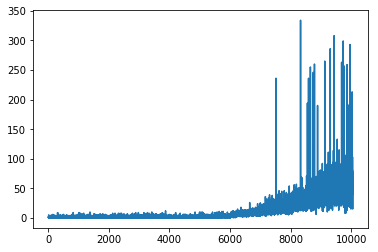

In [30]:
plt.plot(fitter.train_reward_ls)

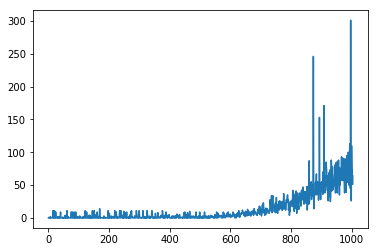

In [31]:
plt.plot(fitter.test_reward_ls)

tensor([[0.8572, 0.9168, 0.8955, 0.8678]], device='cuda:0')
tensor([[0.7344, 0.7749, 0.7960, 0.7344]], device='cuda:0')
tensor([[0.9327, 0.9411, 0.8770, 0.9452]], device='cuda:0')
tensor([[0.5917, 0.5709, 0.6286, 0.5887]], device='cuda:0')
tensor([[0.3456, 0.3642, 0.3474, 0.3557]], device='cuda:0')
tensor([[0.1723, 0.1992, 0.2139, 0.1884]], device='cuda:0')
tensor([[1.1974, 1.2020, 1.2044, 1.2440]], device='cuda:0')
tensor([[0.2510, 0.2695, 0.2752, 0.2786]], device='cuda:0')
tensor([[0.2836, 0.3277, 0.3246, 0.3347]], device='cuda:0')
tensor([[0.4145, 0.4218, 0.4354, 0.4101]], device='cuda:0')
tensor([[0.4582, 0.4521, 0.4648, 0.4324]], device='cuda:0')
tensor([[0.3075, 0.3675, 0.3347, 0.3342]], device='cuda:0')
tensor([[0.0904, 0.1190, 0.1116, 0.1297]], device='cuda:0')
tensor([[0.5534, 0.5607, 0.5877, 0.5788]], device='cuda:0')
tensor([[0.2532, 0.3144, 0.2847, 0.2793]], device='cuda:0')
tensor([[0.5022, 0.5255, 0.4985, 0.5610]], device='cuda:0')
tensor([[0.8848, 0.9018, 0.8901, 0.8697]

Counter({1: 31, 2: 42, 3: 20, 0: 7})

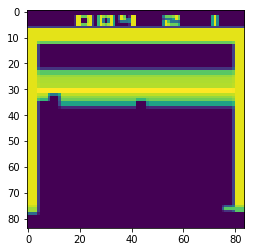

In [23]:
from collections import Counter

ls = []
S_ls = []
for _ in range(100):
    S = fitter.replay_memory.sample(1)[0][0]
    print(fitter.behavior_net(S).data)
    #print(fitter.behavior_net(S).argmax().item())
    ls.append(fitter.behavior_net(S).argmax().item())
    #plt.imshow(S[3])
plt.imshow(S[0])
Counter(ls)

In [79]:
def play_game(fitter):
    fitter.reset_episode()
    img = plt.imshow(fitter.env.render(mode='rgb_array')) # only call this once
    
    done=False
    while not done:
        img.set_data(fitter.env.render(mode='rgb_array')) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        fitter.run_k_frames(is_training=False)
    
    fitter.env.close()
    return

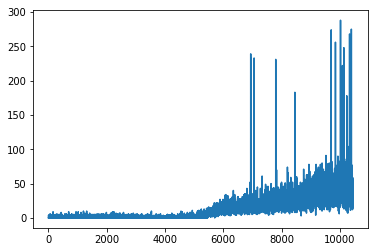

In [59]:
plt.plot(fitter.train_reward_ls)

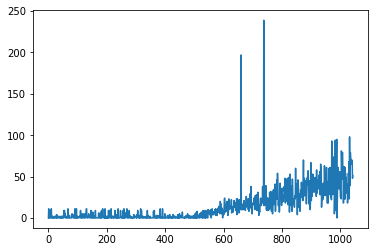

In [60]:
plt.plot(fitter.test_reward_ls)